In [198]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [199]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [200]:
DATA_DIR = "/kaggle/input/casia1000"

In [201]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([ tt.Resize(image_size),
                                                        tt.CenterCrop(image_size),
                                                        tt.ToTensor(),
                                                        tt.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [202]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [203]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break


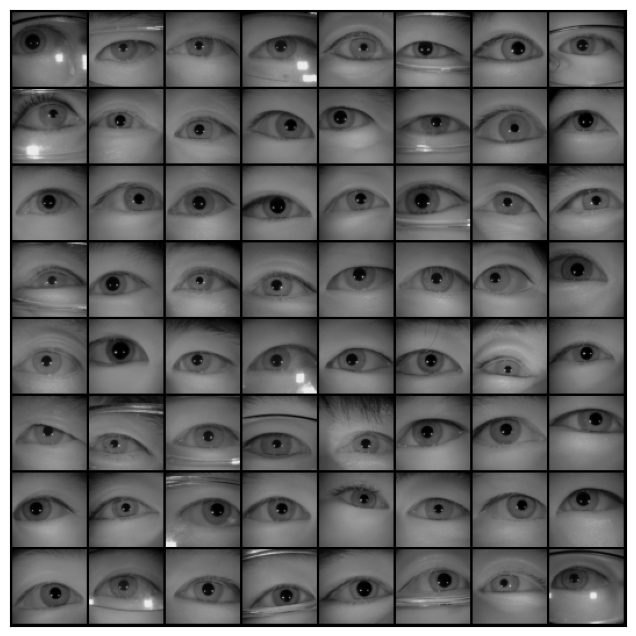

In [204]:
show_batch(train_dl)

In [205]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


In [206]:
device = get_default_device()
device

device(type='cuda')

In [207]:
train_dl = DeviceDataLoader(train_dl, device)

In [208]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8
    
    nn.Conv2d(256, 1, kernel_size=8, stride=1, padding=0, bias=False),

#     nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(512),
#     nn.LeakyReLU(0.2, inplace=True),
#     # out: 512 x 4 x 4     

#     nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()
)



In [209]:
discriminator = to_device(discriminator, device)

In [210]:
latent_size = 128

In [211]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

In [212]:
generator = to_device(generator, device)

In [213]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()
    
    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
#     latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    latent = torch.randn((real_images).size(0), latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
#     print(fake_preds.size())
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
#     loss = real_loss + fake_loss

    #y_pred: real_preds
    #y : real_targets
    #y_pred_fake: fake_preds
    #y2 : fake_targets
    
    #RASGAN : errD = ((BCE_stable(y_pred - torch.mean(y_pred_fake), y) + BCE_stable(y_pred_fake - torch.mean(y_pred), y2))/2
    
    BCE_stable = nn.BCEWithLogitsLoss()
#     BCE_stable = torch.nn.BCELoss()
#     loss = BCE_stable(real_preds - fake_preds, real_targets)
    loss = ((BCE_stable(real_preds - torch.mean(fake_preds), real_targets) + BCE_stable(fake_preds - torch.mean(real_preds), fake_targets)))/2

    loss.backward()
#     for p in discriminator.parameters():
#         print(p.grad)
        
    opt_d.step()
    return loss.item(), real_score, fake_score

In [214]:
def train_generator(real_images , opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    #extra for RSGAN
    real_preds = discriminator(real_images)
   
    
    # Generate fake images
    latent = torch.randn(len(real_images), latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones((real_images).size(0), 1, device=device)
    
    fake_targets = torch.zeros((real_images).size(0), 1, device=device)
#     loss = F.binary_cross_entropy(preds, targets) 
    BCE_stable = nn.BCEWithLogitsLoss()
#     BCE_stable = torch.nn.BCELoss()
#     BCE_stable = F.binary_cross_entropy
#     loss = BCE_stable(preds - real_preds, targets)
    loss = ((BCE_stable(real_preds - torch.mean(preds), fake_targets) + BCE_stable(preds - torch.mean(real_preds), targets)))/2

#     print(preds - real_preds)
    # Update generator weights
    loss.backward()
#     for p in generator.parameters():
#         print(p.grad)
    opt_g.step()
    
    return loss.item()      

In [215]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [216]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.jpg'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [217]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.jpg


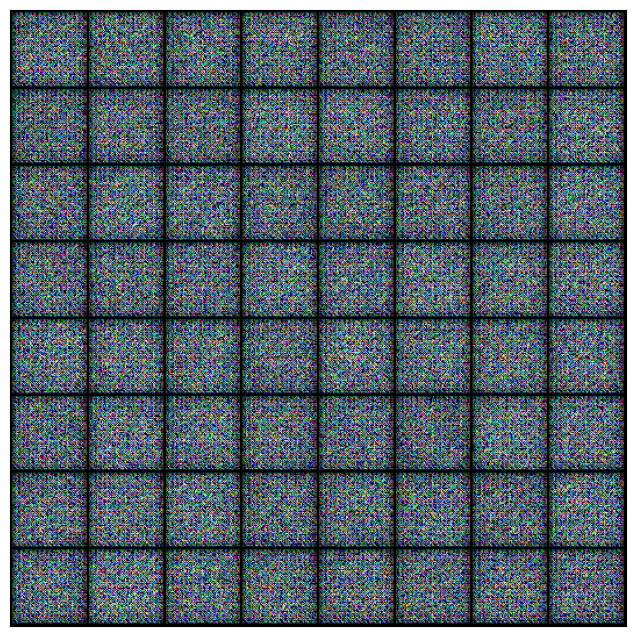

In [218]:
save_samples(0, fixed_latent)

In [219]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(real_images , opt_g)
#             print(loss_d,loss_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {}, loss_d: {}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores


In [220]:
# lr = 0.0002
lr = 0.01
epochs = 2


In [221]:
history = fit(epochs, lr)

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [1/60], loss_g: 0.6931471824645996, loss_d: 0.6931471824645996, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0001.jpg


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [3/60], loss_g: 0.6931471824645996, loss_d: 0.6931471824645996, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0003.jpg


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [4/60], loss_g: 0.6931471824645996, loss_d: 0.6931471824645996, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0004.jpg


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [5/60], loss_g: 0.6931471824645996, loss_d: 0.6931471824645996, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0005.jpg


  0%|          | 0/157 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
losses_g, losses_d, real_scores, fake_scores = history


In [ ]:
# from IPython.display import Image
# Image('./generated/generated-images-0060.jpg')